In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline

In [2]:
train = pd.read_csv("googleplaystore.csv")

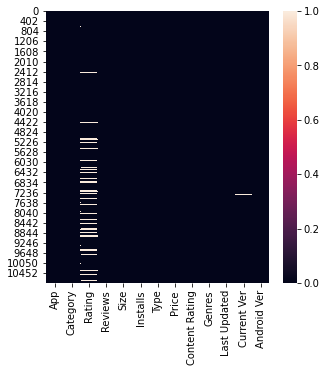

In [3]:
plt.figure(figsize=(5,5))
sns.heatmap(train.isnull())

In [4]:
train.dropna(axis=0, inplace=True)

In [5]:
def get_android_ver(x):
    if x == "Varies with device":
        return 4           # 4 it's median
    else:
        palavra =  re.findall(r'[^a-zA-Z]',x)
        palavra = "".join(palavra)
        return float(palavra[:3])

In [6]:
train['Android Ver'] = train['Android Ver'].apply(lambda x: get_android_ver(x))

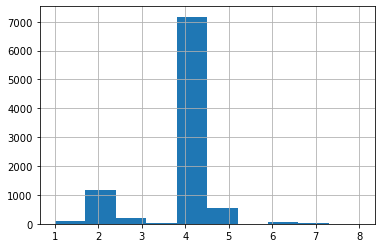

In [7]:
train['Android Ver'].hist()

In [8]:
print(train['Android Ver'].median())

4.0


In [9]:
def get_string(x):
    if (len(x)) >5:
        return x
    elif (len(x)) <=5:
        string = re.findall(r'[a-zA-Z]',x)
        return "".join(string)
    
def get_number(x):
    number =  re.findall(r'[^a-zA-Z]',x)
    if len(x) > 5:
        return 0   # analisar essa parte
    else:
        return float("".join(number))

In [10]:
train['Strings'] = train['Size'].apply(lambda x: get_string(x))
train['Numbers'] = train['Size'].apply(lambda x: float(get_number(x)))

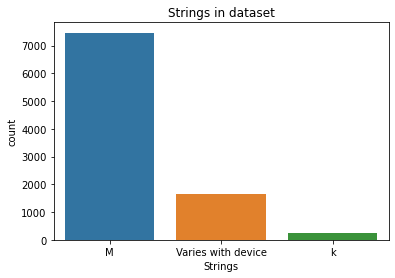

In [11]:
plt.title('Strings in dataset')
sns.countplot(train['Strings'])

In [12]:
def get_size(cols):
    letra = cols[0]
    numero = cols[1]
    if letra == 'k':
        tamanho = numero /1024
        return tamanho
    elif letra == 'M':
        tamanho = numero /1 
        return tamanho
    else:
        return "none"

In [13]:
train['Size'] = train[['Strings','Numbers']].apply(get_size, axis=1)

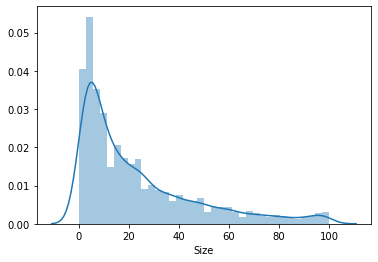

In [14]:
mediansize = train[train['Size']!='none']
sns.distplot(mediansize['Size'])

In [15]:
def get_size2(x):
    if x == "none":
        return 22.97
    else:
        return x

In [16]:
train['Size'] = train['Size'].apply(lambda x: get_size2(x))

In [17]:
def get_installs(x):
    x = x.replace(",","")
    x = x.replace("+","")
    return int(x)

In [18]:
train['Installs'] = train['Installs'].apply(lambda x: int(get_installs(x)))

In [19]:
train['Last Updated'] = train['Last Updated'].apply(lambda x: "".join(l for l in x if l not in string.punctuation))
train['Last Updated'] = train['Last Updated'].apply(lambda x: x.split())

In [20]:
train['Last Updated'].head()

0     [January, 7, 2018]
1    [January, 15, 2018]
2      [August, 1, 2018]
3        [June, 8, 2018]
4       [June, 20, 2018]
Name: Last Updated, dtype: object

In [21]:
train['Ano'] = train['Last Updated'][0][2]
train['Mês'] = train['Last Updated'][0][0]

In [22]:
months = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
          'August':8, 'September':9, 'October':10, 'November':11,'December':12 }

In [23]:
train['Mês'] = train['Mês'].apply(lambda x: months.get(x))
train['Ano'] =train['Ano'].astype(int)
train['Mês'] =train['Mês'].astype(int)

In [24]:
train['Reviews'] = train['Reviews'].astype(int)
def get_price(x):
    numero = re.findall('[^$]', x)
    return "".join(numero)


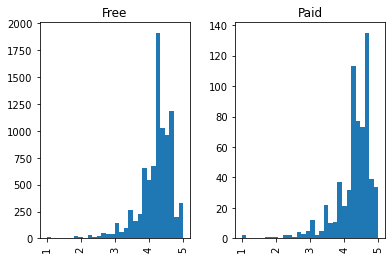

In [25]:
train['Price'] = train['Price'].apply(lambda x: get_price(x))
train['Price'] = train['Price'].astype(float)
train['Rating'].hist(bins=30, by=train['Type'])
train[['Type','Rating']].groupby('Type').mean()
category = train[['Category','Rating']].groupby('Category').mean().sort_values(ascending=False,by='Rating')

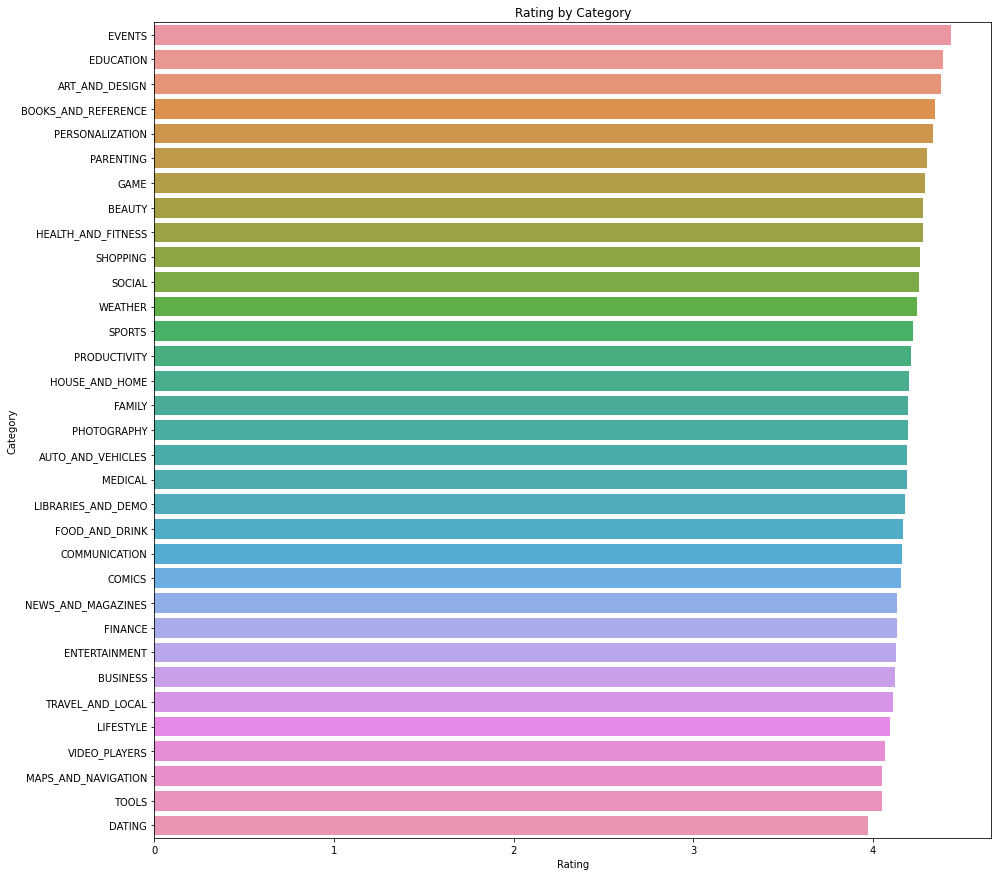

In [26]:
plt.figure(figsize=(15,15))
plt.title("Rating by Category")
sns.barplot(x=category['Rating'], y=category.index)

In [27]:
train.drop(['Strings','Numbers','Current Ver','Last Updated'],axis=1, inplace=True)

In [28]:
objectcol = list(train.select_dtypes(include='object').columns)
objectcol

['App', 'Category', 'Type', 'Content Rating', 'Genres']

In [29]:
badcol = []
goodcol = []
for col in objectcol:
    nunique = train[col].nunique()
    print(f'{col}: {nunique}')
    if nunique > 10:
        badcol.append(col)
    else:
        goodcol.append(col)

App: 8190
Category: 33
Type: 2
Content Rating: 6
Genres: 115


In [30]:
print(badcol)
print(goodcol)

['App', 'Category', 'Genres']
['Type', 'Content Rating']


In [31]:
typedummie = pd.get_dummies(train['Type'])
train = pd.concat([train,typedummie],axis=1)
ratingdummie = pd.get_dummies(train['Content Rating'])
train = pd.concat([train,ratingdummie],axis=1)
train.drop(goodcol, axis=1, inplace=True)
train.drop(['App','Genres','Category'], axis=1, inplace=True)
train.head()

,Rating,Reviews,Size,Installs,Price,Android Ver,Ano,Mês,Free,Paid,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,4.1,159,19.0,10000,0.0,4.0,2018,1,1,0,0,1,0,0,0,0
1,3.9,967,14.0,500000,0.0,4.0,2018,1,1,0,0,1,0,0,0,0
2,4.7,87510,8.7,5000000,0.0,4.0,2018,1,1,0,0,1,0,0,0,0
3,4.5,215644,25.0,50000000,0.0,4.2,2018,1,1,0,0,0,0,0,1,0
4,4.3,967,2.8,100000,0.0,4.4,2018,1,1,0,0,1,0,0,0,0


In [32]:
train.shape

(9360, 16)

In [33]:
y = train['Rating']
x = train.drop('Rating',axis=1)

In [34]:
y = train['Rating']
x = train.drop('Rating',axis=1)

In [35]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3, random_state=42)

In [36]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
xtrain=sc_X.fit_transform(xtrain)
xtest=sc_X.transform(xtest)

In [37]:
from sklearn.tree import DecisionTreeRegressor

In [38]:
def score_dataset(xtrain,xtest,ytrain,ytest,n_estimators):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(xtrain,ytrain)
    pred = model.predict(xtest)
    return mean_squared_error(ytest,pred)

In [56]:
index = []
score = []
for n in [150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600]:
    index.append(n)
    score.append(score_dataset(xtrain,xtest,ytrain,ytest,n,))

Text(0, 0.5, 'Mean Squared Error')

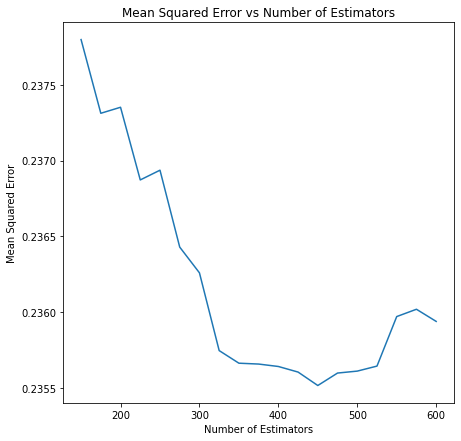

In [57]:
plt.figure(figsize=(7,7))
plt.title('Mean Squared Error vs Number of Estimators')
sns.lineplot(x=index,y=score)
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')

In [60]:
model = RandomForestRegressor(n_estimators=425, random_state=42)
model.fit(xtrain,ytrain)
predict = model.predict(xtest)
mean_squared_error(ytest,predict)

0.2356054639567103

In [61]:
print(f' Mean Squared Error: {mean_squared_error(ytest, predict)}')

 Mean Squared Error: 0.2356054639567103


In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [51]:
my_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                              ('model', RandomForestRegressor(n_estimators=400,
                                                              random_state=42))
                             ])

In [52]:
scores = -1 * cross_val_score(my_pipeline, x, y,
                              cv=5,
                              scoring='mean_squared_error')

print("MAE scores:\n", scores)

ValueError: 'mean_squared_error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [ ]:
index = np.arange(1,6)

In [ ]:
plt.figure(figsize=(7,7))
plt.title('Mean Absolut Error')
sns.lineplot(x=index,y=scores)
plt.xlabel('cv')
plt.ylabel('mae')

In [ ]:
print(scores.mean())